In [ ]:
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import scipy.interpolate
import numpy as np
import scipy as sp
import random

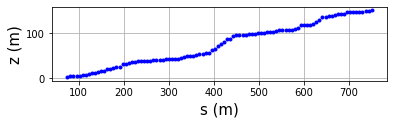

In [ ]:
def dibujaRio(datos=np.loadtxt("PuntosRio.csv", delimiter = ",")):

    s = datos[:,0]
    z = datos[:,1]
    
    plt.plot(s,z,'b.')
    plt.grid (True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel('s (m)', fontsize = 15)
    plt.ylabel('z (m)', fontsize = 15)

dibujaRio()

In [ ]:
def dibujaSolucion(individuo, datos = np.loadtxt("PuntosRio.csv", delimiter = ",")):
    s = datos[:,0]
    z = datos[:,1]

    nodos   = np.nonzero(individuo)[0]
    s_nodos = s[nodos]
    z_nodos = z[nodos]
    
    plt.plot(s,z)
    plt.plot(s_nodos,z_nodos,'-ok')
    
    plt.grid (True)

    plt.xlabel('s (m)', fontsize = 15)
    plt.ylabel('z (m)', fontsize = 15)
    plt.legend({'Río','Trazado óptimo'})
    
    # Misma escala en ambos ejes
    plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
def plot_evolucion(log):
    """
    Representa la evolución del mejor individuo en cada generación
    """
    gen = log.select("gen")
    fit_mins = log.select("min")
    fit_maxs = log.select("max")
    fit_ave = log.select("avg")

    fig, ax1 = plt.subplots()
    ax1.plot(gen, fit_mins, "b")
    ax1.plot(gen, fit_maxs, "r")
    ax1.plot(gen, fit_ave, "--k")

    ax1.fill_between(gen, fit_mins, fit_maxs, facecolor='g', alpha = 0.2)
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness")
    ax1.legend(["Min", "Max", "Avg"], loc="lower center")
    plt.grid(True)

/root/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Problema1' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/root/venv/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'individuo' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


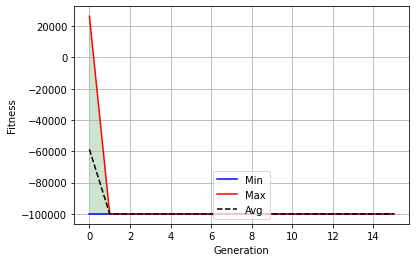

In [ ]:
# Generación de inidviduos
def crea_individuo(size= 100):
    individuo = [0 for n in range(size)]
    x1 = random.randint(0, size-1)
    x2 = random.randint(0, size-1)
    if x1 > x2:
        x3 = x1
        x1 = x2
        x2 = x3
    elif x1 == x2:
        if x2 < size - 2:
            x2 = x2 + 2
        else:
            x1 = x1 - 2
            
    if (x2 == (x1 + 1)):
        if x2 < size -2:
            x2 = x2 + 1
        else:
            x1 = x1 - 1
       
    individuo[x1:x2] = [1 for n in range(x2-x1)]

    return individuo


# Operador de mutación
def mutFlipBitAs (individuo, indpb_01, indpb_10):
    for j, i in enumerate(individuo):
        if i == 1:
            if random.random() <= indpb_10:
                individuo[j] = 0
        if i == 0:
            if random.random() <= indpb_01:
                individuo[j] = 1
    return individuo,


# Prestaciones de la planta
def validaTrazado(individuo, datos):
    
    max_sop = 1.70
    max_exc = 1.20
    
    s = datos[:,0]
    z = datos[:,1]
    
    nodos = np.nonzero(individuo)[0]
    
    # Individuos de menos de 2 nodos no son válidos
    if len(nodos) < 2:
        return False

    s_nodos = s[nodos]
    z_nodos = z[nodos]
    trazado = sp.interpolate.interp1d(s_nodos, z_nodos)

    comprueba_sop = trazado(s[nodos[0]:nodos[-1]]) - z[nodos[0]:nodos[-1]]
    comprueba_exc = -1 * comprueba_sop

    # Comprobación de restricciones
    if (all(comprueba_sop <= max_sop) == False):
        return False
    if (all(comprueba_exc <= max_exc) == False):
        return False
    
    return True


# Prestaciones (potencia y coste) de la planta
def validaPlanta(individuo, datos):

    Pmin = 7e3
    Dtf  = 32e-2
    C0   = 25
    RHO  = 1000
    G    = 9.8
    F    = 2e-3
    DNOZ = 22e-3
    SNOZ = (np.pi*DNOZ**2)/4
    REND = 0.9
    
    s = datos[:,0]
    z = datos[:,1]

    nodos   = np.nonzero(individuo)[0]
    s_nodos = s[nodos]
    z_nodos = z[nodos]

    Hg  = z[nodos[-1]] - z[nodos[0]] # diferencia de altura
    Ltf = np.sum(np.sqrt((s_nodos[1:] - s_nodos[0:-1])**2 + (z_nodos[1:] - z_nodos[0:-1])**2))
    Nc  = sum(np.array(individuo))
    P   = REND * (RHO/(2*SNOZ**2))*(Hg/(1/(2*G*SNOZ**2) + F*Ltf/(Dtf**5)))**(3/2)
    C   = 700*(Ltf + C0 * Nc) * Dtf**2
    
    cumplePotencia = False
    if P>=Pmin:
        cumplePotencia = True

    return P, C, cumplePotencia


# Función de fitness para el problema monoobjetivo
def fitness_function_single(individuo, datos):
    penaliza = 100000
    
    if validaTrazado(individuo, datos)==False:
        return penaliza,
    else:
        P, C, cumplePotencia = validaPlanta(individuo, datos)
    
    if cumplePotencia==False:
        return penaliza,

    return C,


# Función de fitness para el problema multiobjetivo
def fitness_function_multiobjetivo(individuo, datos):
    penaliza = 100000
    
    if validaTrazado(individuo, datos)==False:
        return -penaliza, penaliza,
    
    P, C, cumplePotencia = validaPlanta(individuo, datos)
    
    if cumplePotencia==False:
        return -penaliza, penaliza,

    return P, C


# Algoritmo monoobjetivo
def unico_objetivo_ga(NGEN, MU, CXPB, MUTPB):
    """ Los parámetros de entrada son la probabilidad de cruce y la
    probabilidad de mutación """
    
    LAMBDA = MU
    pop = toolbox.ini_poblacion(n=MU)
    hof = tools.HallOfFame(1)
    
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    logbook = tools.Logbook()
    
    pop, logbook = algorithms.eaMuPlusLambda(
        pop, toolbox, MU, LAMBDA, 
        CXPB, MUTPB, NGEN, stats=stats, halloffame=hof, verbose=False
    )
    
    return pop, hof, logbook


# Ejecución del algoritmo monoobjetivo
  
# paso1: Creación del problema
creator.create("Problema1", base.Fitness, weights=(-1,))
    
# paso2: Generación de individuos
creator.create("individuo", list, fitness=creator.Problema1)
   
# Creamos la caja de herramientas
toolbox = base.Toolbox()
    
# Registramos nuevas funciones
toolbox.register("individuo", tools.initIterate, creator.individuo, crea_individuo)
toolbox.register("ini_poblacion", tools.initRepeat, list, toolbox.individuo)
    
# Operaciones genéticas
toolbox.register("evaluate", fitness_function_single, datos=np.loadtxt("PuntosRio.csv", delimiter=","))
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutFlipBitAs, indpb_01=0.2, indpb_10=0.8)
toolbox.register("select", tools.selTournament, tournsize = 3)
    
# Operaciones genéticas
toolbox.register("evaluate", fitness_function_multiobjetivo, datos=np.loadtxt("PuntosRio.csv", delimiter=","))
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutFlipBitAs, indpb_01=0.2, indpb_10=0.8)
toolbox.register("select", tools.selNSGA2)


multi, pcx, pmut = False, 0.7, 0.3
pop_new, hof, log = unico_objetivo_ga(15, 3000, pcx, pmut)
plot_evolucion(log)

In [ ]:
# Generación de inidviduos
def crea_individuo(size= 100):
    individuo = [0 for n in range(size)]
    x1 = random.randint(0, size-1)
    x2 = random.randint(0, size-1)
    if x1 > x2:
        x3 = x1
        x1 = x2
        x2 = x3
    elif x1 == x2:
        if x2 < size - 2:
            x2 = x2 + 2
        else:
            x1 = x1 - 2
            
    if (x2 == (x1 + 1)):
        if x2 < size -2:
            x2 = x2 + 1
        else:
            x1 = x1 - 1
       
    individuo[x1:x2] = [1 for n in range(x2-x1)]
    return individuo

    
# Operador de mutación
def mutFlipBitAs (individuo, indpb_01, indpb_10):
    for j, i in enumerate(individuo):
        if i == 1:
            if random.random() <= indpb_10:
                individuo[j] = 0
        if i == 0:
            if random.random() <= indpb_01:
                individuo[j] = 1
    return individuo,


# Prestaciones de la planta
def validaTrazado(individuo, datos):
    
    max_sop = 1.70
    max_exc = 1.20
    
    s = datos[:,0]
    z = datos[:,1]
    
    nodos = np.nonzero(individuo)[0]
    
    # Individuos de menos de 2 nodos no son válidos
    if len(nodos) < 2:
        return False

    s_nodos = s[nodos]
    z_nodos = z[nodos]
    trazado = sp.interpolate.interp1d(s_nodos, z_nodos)

    comprueba_sop = trazado(s[nodos[0]:nodos[-1]]) - z[nodos[0]:nodos[-1]]
    comprueba_exc = -1 * comprueba_sop

    # Comprobación de restricciones
    if (all(comprueba_sop <= max_sop) == False):
        return False
    if (all(comprueba_exc <= max_exc) == False):
        return False
    
    return True

# Prestaciones (potencia y coste) de la planta
def validaPlanta(individuo, datos):

    Pmin = 7e3
    Dtf  = 32e-2
    C0   = 25
    RHO  = 1000
    G    = 9.8
    F    = 2e-3
    DNOZ = 22e-3
    SNOZ = (np.pi*DNOZ**2)/4
    REND = 0.9
    
    s = datos[:,0]
    z = datos[:,1]

    nodos   = np.nonzero(individuo)[0]
    s_nodos = s[nodos]
    z_nodos = z[nodos]

    Hg  = z[nodos[-1]] - z[nodos[0]] # diferencia de altura
    Ltf = np.sum(np.sqrt((s_nodos[1:] - s_nodos[0:-1])**2 + (z_nodos[1:] - z_nodos[0:-1])**2))
    Nc  = sum(np.array(individuo))
    P   = REND * (RHO/(2*SNOZ**2))*(Hg/(1/(2*G*SNOZ**2) + F*Ltf/(Dtf**5)))**(3/2)
    C   = 700*(Ltf + C0 * Nc) * Dtf**2
    
    cumplePotencia = False
    if P>=Pmin:
        cumplePotencia = True
    
    return P, C, cumplePotencia


# Función de fitness para el problema multiobjetivo
def fitness_function_multiobjetivo(individuo, datos):
    penaliza = 100000
    
    if validaTrazado(individuo, datos)==False:
        return -penaliza, penaliza,
    
    P, C, cumplePotencia = validaPlanta(individuo, datos)
    
    if cumplePotencia==False:
        return -penaliza, penaliza

    return P, C


# Algoritmo multiobjetivo
def multi_objetivo_ga(NGEN, MU, CXPB, MUTPB):
    """ Los parámetros de entrada son la probabilidad de cruce y la
    probabilidad de mutación"""
    
    LAMBDA = MU
    pop = toolbox.ini_poblacion(n=MU)
    hof = tools.ParetoFront()    
    
    algorithms.eaMuPlusLambda(
        pop, toolbox, MU,
        LAMBDA, CXPB, MUTPB, NGEN,
        halloffame=hof, verbose=False
    )
    
    return pop, hof


# Ejecución del algoritmo multiobjetivo
    
# paso1: Creación del problema
creator.create("Problema1", base.Fitness, weights=(1.0,-1.0))
    
# paso2: Generación de individuos
creator.create("individuo", list, fitness=creator.Problema1)
    
# Creamos la caja de herramientas
toolbox = base.Toolbox() 

# Registramos nuevas funciones
toolbox.register("individuo", tools.initIterate, creator.individuo, crea_individuo)
toolbox.register("ini_poblacion", tools.initRepeat, list, toolbox.individuo)
    
# Operaciones genéticas
toolbox.register("evaluate", fitness_function_multiobjetivo, datos=np.loadtxt("PuntosRio.csv", delimiter=","))
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutFlipBitAs, indpb_01=0.2, indpb_10=0.8)
toolbox.register("select", tools.selNSGA2)
    
# Se realiza la llamada a la resolcuión del problema
pcx, pmut = 0.7, 0.3
pop_new, pareto_new, log = multi_objetivo_ga(100, 2000, pcx, pmut)
plot_evolucion(log)

ValueError: not enough values to unpack (expected 3, got 2)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=183a4102-ed36-4d8f-a68e-0f907c31c07b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>